In [ ]:
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from scipy.stats.stats import pearsonr

In [ ]:
def get_stats(S):
    max_ = S.max()
    min_ = S.min()
    std_ = S.std()
    avg_ = S.mean()
    return max_, min_, std_, avg_

def get_features(df):
    max_avP, min_avP, std_avP, avg_avP = get_stats(df.avP)
    max_dP, min_dP, std_dP, avg_dP = get_stats(df.dP)
    max_avI, min_avI, std_avI, avg_avI = get_stats(df.avI)
    max_dI, min_dI, std_dI, avg_dI = get_stats(df.dI)
    max_f1, min_f1, std_f1, avg_f1 = get_stats(df.f1)
    max_dF1, min_dF1, std_dF1, avg_dF1 = get_stats(df.dF1)
    max_f2, min_f2, std_f2, avg_f2 = get_stats(df.f2)
    max_dF2, min_dF2, std_dF2, avg_dF2 = get_stats(df.dF2)
    max_h, min_h, std_h, avg_h = get_stats(df.h)
    return dict(id = df.id[0],
        max_avP = max_avP, min_avP = min_avP, std_avP = std_avP, avg_avP = avg_avP,
        max_dP = max_dP, min_dP = min_dP, std_dP = std_dP, avg_dP = avg_dP,
        max_avI = max_avI, min_avI = min_avI, std_avI = std_avI, avg_avI = avg_avI,
        max_dI = max_dI, min_dI = min_dI, std_dI = std_dI, avg_dI = avg_dI,
        max_f1 = max_f1, min_f1 = min_f1, std_f1 = std_f1, avg_f1 = avg_f1,
        max_dF1 = max_dF1, min_dF1 = min_dF1, std_dF1 = std_dF1, avg_dF1 = avg_dF1,
        max_f2 = max_f2, min_f2 = min_f2, std_f2 = std_f2, avg_f2 = avg_f2,
        max_dF2 = max_dF2, min_dF2 = min_dF2, std_dF2 = std_dF2, avg_dF2 = avg_dF2,
        max_h = max_h, min_h = min_h, std_h = std_h, avg_h = avg_h)

def preprocess_audio(directory):
    all_files = os.listdir(directory)
    data = []

    for file in all_files:
        filename = directory + file
        df = pd.read_csv(filename, sep = '\t')
        df['id'] = filename[16:-4]
        features = get_features(df)
        data.append(features)

    data = pd.DataFrame.from_dict(data)
    cols = data.columns.tolist()
    cols.remove('id')
    cols = ['id'] + cols
    data = data[cols]
    return data

In [ ]:
def preprocess_scores(directory):
    all_files = os.listdir(directory)
    scores_dfs = []
    for file in all_files:
        filename = directory + file
        scores = pd.read_csv(filename)
        scores.columns = ['id', 'Ext', 'Agr', 'Con', 'Neur', 'Open']
        ext_avg = scores.Ext.mean()
        agr_avg = scores.Agr.mean()
        con_avg = scores.Con.mean()
        neur_avg = scores.Neur.mean()
        open_avg = scores.Open.mean()
        averages = (ext_avg, agr_avg, con_avg, neur_avg, open_avg)
        def classify(row, averages = averages):
            def get_class(score,avg):
                if score > avg: return 1
                else: return 0

            ext_avg, agr_avg, con_avg, neur_avg, open_avg = averages
            class_ext = get_class(row.Ext, ext_avg)
            class_agr = get_class(row.Agr, agr_avg)
            class_con = get_class(row.Con, con_avg)
            class_neur = get_class(row.Neur, neur_avg)
            class_open = get_class(row.Open, open_avg)
            return (class_ext, class_agr, class_con, class_neur, class_open)

        scores['Ext'], scores["Agr"], scores["Con"], scores["Neur"], scores["Open"] = zip(*scores.apply(classify,axis=1))
        scores_dfs.append(scores)
    ids = scores_dfs[0].id
    scores = scores_dfs[0].drop('id',axis=1)
    for i in range(1,len(scores_dfs)):
        scores = scores.add(scores_dfs[i].drop('id',axis=1))
    scores['id'] = ids
    return scores

In [ ]:
data = preprocess_audio('../output/')
scores = preprocess_scores('../SSPNet-Speaker-Personality-Corpus/Personality_Scores/')
df = data.merge(scores, on='id', how='left')

In [ ]:
def mkdata(df, trait_name, threshold = 1):
    traits = ['Ext', 'Agr', 'Con', 'Neur', 'Open']
    traits.remove(trait_name)
    data = df.drop(traits, axis=1)
    data = data.drop(['id'], axis=1)
    def labelify(row):
        if row[trait_name] > 6 + threshold: return 1
        elif row[trait_name] < 6 - threshold: return 0
        else: return -1
    data[trait_name] = data.apply(labelify, axis = 1)
    data = data[data[trait_name] >= 0]
    data = data.rename(columns = {trait_name: 'label'})
    return data

In [ ]:
def get_score(data, get_features = 0):
    X_train, X_test, y_train, y_test = train_test_split(data.drop('label', axis = 1), data.label, test_size=0.10, random_state=42)

    model = AdaBoostClassifier()
    model.fit(X_train, y_train)
    if get_features:
        return model.feature_importances

    #return model.score(X_test, y_test)
    print(model.predict(X_test))
    return model

In [ ]:
#Trait
traits = ['Ext', 'Agr', 'Con', 'Neur', 'Open']
models = []
for label in traits:
    data = mkdata(df,label,1)
    models.append(get_score(data))

In [ ]:
models[0].predict(all_data.drop(['id','speaker'], axis=1))

In [ ]:
#Threshold analysis
traits = ['Ext', 'Agr', 'Con', 'Neur', 'Open']
for label in traits:
    threshold_scores = []
    for i in range(0,3):
        data = mkdata(df,label,i)
        threshold_scores.append(get_score(data))
    plt.plot(threshold_scores)
plt.title('Threshold Analysis over traits')
plt.legend(traits)
plt.ylabel('Validation Accuracy')
plt.xlabel('Threshold')
plt.show()

In [ ]:
#Model accuracy
threshold = 1
traits = ['Ext', 'Agr', 'Con', 'Neur', 'Open']
scores = []

for label in traits:
    data = mkdata(df,label,threshold)
    #data=data.drop(['avg_h','min_h','max_h','std_h'],axis=1)
    scores.append(get_score(data))
for i, score in enumerate(scores):
    print(traits[i], score)

In [ ]:
#Feature importances
data = mkdata(df,'Ext',1)
#data=data.drop(['avg_h','min_h','max_h','std_h'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(data.drop('label', axis = 1), data.label, test_size=0.20, random_state=42)

model = AdaBoostClassifier()
model.fit(X_train, y_train)
importances = model.feature_importances_
features = list(X_train)
for i, importance in enumerate(importances):
    #print(features[i], importance)
    if importance > 0.06:
        plt.bar(features[i],importance)
        
plt.title("Feature Importances")
plt.xlabel("feature")
plt.ylabel('coefficient')

In [ ]:
y = pd.read_csv('conflictlevel.csv')
y.columns = ['id', 'score']

def get_features(df):
    max_avP, min_avP, std_avP, avg_avP = get_stats(df.avP)
    max_dP, min_dP, std_dP, avg_dP = get_stats(df.dP)
    max_avI, min_avI, std_avI, avg_avI = get_stats(df.avI)
    max_dI, min_dI, std_dI, avg_dI = get_stats(df.dI)
    max_f1, min_f1, std_f1, avg_f1 = get_stats(df.f1)
    max_dF1, min_dF1, std_dF1, avg_dF1 = get_stats(df.dF1)
    max_f2, min_f2, std_f2, avg_f2 = get_stats(df.f2)
    max_dF2, min_dF2, std_dF2, avg_dF2 = get_stats(df.dF2)
    max_h, min_h, std_h, avg_h = get_stats(df.h)
    return dict(id = df.id[df.id.index[0]],
        max_avP = max_avP, min_avP = min_avP, std_avP = std_avP, avg_avP = avg_avP,
        max_dP = max_dP, min_dP = min_dP, std_dP = std_dP, avg_dP = avg_dP,
        max_avI = max_avI, min_avI = min_avI, std_avI = std_avI, avg_avI = avg_avI,
        max_dI = max_dI, min_dI = min_dI, std_dI = std_dI, avg_dI = avg_dI,
        max_f1 = max_f1, min_f1 = min_f1, std_f1 = std_f1, avg_f1 = avg_f1,
        max_dF1 = max_dF1, min_dF1 = min_dF1, std_dF1 = std_dF1, avg_dF1 = avg_dF1,
        max_f2 = max_f2, min_f2 = min_f2, std_f2 = std_f2, avg_f2 = avg_f2,
        max_dF2 = max_dF2, min_dF2 = min_dF2, std_dF2 = std_dF2, avg_dF2 = avg_dF2,
        max_h = max_h, min_h = min_h, std_h = std_h, avg_h = avg_h)

directory = '../Conflict/output/'
diary_directory = '../Conflict/manualdiarization/'
all_files = os.listdir(directory)
pers_data = []
for file in all_files:
#file = all_files[1]
    filename = directory + file
    data = pd.read_csv(filename, sep = '\t')
    data['id'] = filename[19:-4]

    diary_file = file[6:-4]  
    diary_filename = diary_directory + diary_file + '.csv'

    dia = pd.read_csv(diary_filename,error_bad_lines=False)
    #print(diary_filename)
    cols = ['time_end','speaker1']
    if dia.shape[1] > 2:
        cols += ['speaker2']
    #dia.columns[0] = 'time_end'
    #dia.columns[1] = 'speaker1'
    cols = list(dia)
    cols[0] = 'time_end'
    cols[1] = 'speaker1'
    dia.columns = cols
    dia['time_start'] = dia.index
    dia = dia[['time_start'] + cols]
    dia = dia.reset_index()
    def get_steps(row):
        time_start = round(row.time_start / 30 * 600)
        time_end = round(row.time_end / 30 * 600)
        return time_start, time_end
    dia['time_start'],dia['time_end'] = zip(*dia.apply(get_steps,axis=1))
    speakers = list(set(dia.speaker1))
    speaker_times = []
    all_data = []
    for speaker in speakers:
        df = dia[dia.speaker1 == speaker]
        time_steps = set()
        for index, row in df.iterrows():
            time_steps.update(range(row.time_start,row.time_end))
        speaker_data = data
        speaker_data = speaker_data[speaker_data.index.isin(time_steps)]
        speaker_features = get_features(speaker_data)
        speaker_features['speaker'] = speaker
        all_data.append(speaker_features)
    all_data = pd.DataFrame.from_dict(all_data)
    cols = all_data.columns.tolist()
    cols.remove('id')
    cols.remove('speaker')
    cols = ['id'] + ['speaker'] + cols
    all_data = all_data[cols]
    traits = []
    for model in models:
        traits.append(model.predict(all_data.drop(['id','speaker'],axis=1)))
    trait_names = ['Ext', 'Agr', 'Con', 'Neur', 'Open']
    for i,name in enumerate(trait_names):
        all_data[name] = traits[i]
    print(all_data[['speaker','Ext','Agr','Con','Neur','Open']])
    def get_pers_features(trait_list):
        p_sum = trait_list.sum()
        p_mean = trait_list.mean()
        p_std = trait_list.std()
        return p_sum, p_mean, p_std

    ext_sum, ext_mean, ext_std = get_pers_features(all_data.Ext)
    agr_sum, agr_mean, agr_std = get_pers_features(all_data.Agr)
    con_sum, con_mean, con_std = get_pers_features(all_data.Con)
    neur_sum, neur_mean, neur_std = get_pers_features(all_data.Neur)
    open_sum, open_mean, open_std = get_pers_features(all_data.Open)

    pers_features = dict(
        id = diary_file,
        ext_sum = ext_sum, ext_mean = ext_mean, ext_std = ext_std,
        agr_sum = agr_sum, agr_mean = agr_mean, agr_std = agr_std,
        con_sum = con_sum, con_mean = con_mean, con_std = con_std,
        neur_sum = neur_sum, neur_mean = neur_mean, neur_std = neur_std,
        open_sum = open_sum, open_mean = open_mean, open_std = open_std,
        y = y[y.id == diary_file].score.asobject[0]
    )
    pers_data.append(pers_features)
pers_data = pd.DataFrame.from_dict(pers_data)

In [272]:
pers_data = pd.DataFrame.from_dict(pers_data)

In [ ]:
y = pd.read_csv('conflictlevel.csv')
y.columns = ['id', 'score']

In [ ]:
y[y.id == diary_file].score

In [ ]:
def get_stats(S):
    max_ = S.max()
    min_ = S.min()
    std_ = S.std()
    avg_ = S.mean()
    return max_, min_, std_, avg_

def get_features(df):
    max_avP, min_avP, std_avP, avg_avP = get_stats(df.avP)
    max_dP, min_dP, std_dP, avg_dP = get_stats(df.dP)
    max_avI, min_avI, std_avI, avg_avI = get_stats(df.avI)
    max_dI, min_dI, std_dI, avg_dI = get_stats(df.dI)
    max_f1, min_f1, std_f1, avg_f1 = get_stats(df.f1)
    max_dF1, min_dF1, std_dF1, avg_dF1 = get_stats(df.dF1)
    max_f2, min_f2, std_f2, avg_f2 = get_stats(df.f2)
    max_dF2, min_dF2, std_dF2, avg_dF2 = get_stats(df.dF2)
    max_h, min_h, std_h, avg_h = get_stats(df.h)
    return dict(id = df.id[0],
        max_avP = max_avP, min_avP = min_avP, std_avP = std_avP, avg_avP = avg_avP,
        max_dP = max_dP, min_dP = min_dP, std_dP = std_dP, avg_dP = avg_dP,
        max_avI = max_avI, min_avI = min_avI, std_avI = std_avI, avg_avI = avg_avI,
        max_dI = max_dI, min_dI = min_dI, std_dI = std_dI, avg_dI = avg_dI,
        max_f1 = max_f1, min_f1 = min_f1, std_f1 = std_f1, avg_f1 = avg_f1,
        max_dF1 = max_dF1, min_dF1 = min_dF1, std_dF1 = std_dF1, avg_dF1 = avg_dF1,
        max_f2 = max_f2, min_f2 = min_f2, std_f2 = std_f2, avg_f2 = avg_f2,
        max_dF2 = max_dF2, min_dF2 = min_dF2, std_dF2 = std_dF2, avg_dF2 = avg_dF2,
        max_h = max_h, min_h = min_h, std_h = std_h, avg_h = avg_h)

def preprocess_audio(directory):
    all_files = os.listdir(directory)
    data = []
    
    y = pd.read_csv('conflictlevel.csv')
    y.columns = ['id', 'score']
    
    for file in all_files:
        filename = directory + file
        df = pd.read_csv(filename, sep = '\t')
        df['id'] = filename[25:-4]
        features = get_features(df)
        data.append(features)

    data = pd.DataFrame.from_dict(data)
    cols = data.columns.tolist()
    cols.remove('id')
    cols = ['id'] + cols
    data = data[cols]
    def get_y(row):
        out = y[y.id == row.id].score.asobject[0]
        return out
    data['y'] = data.apply(get_y,axis=1)
    return data


In [ ]:
raw_data = preprocess_audio('../Conflict/output/')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(raw_data.drop(['id','y'], axis = 1), raw_data.y, test_size=0.20, random_state=42)

model = AdaBoostRegressor()
model.fit(X_train, y_train)

out = model.predict(X_test)
print(pearsonr(out,y_test))

In [ ]:
#pers and raw_data
def get_score(data):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(['id','y'], axis = 1), data.y, test_size=0.20, random_state=42)

    model = AdaBoostRegressor()
    model.fit(X_train, y_train)

    out = model.predict(X_test)
    return pearsonr(out,y_test)
print(get_score(pers_data.dropna()))
print(get_score(raw_data))
print(get_score(raw_data.merge(pers_data,on=['id','y'],how = 'left').dropna()))

Text(0,0.5,'coefficient')

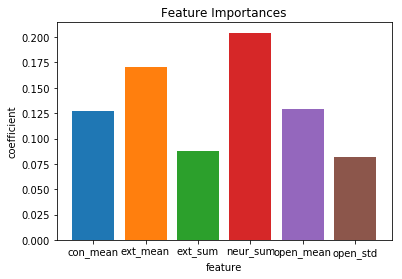

In [278]:
data= pers_data.dropna()
X_train, X_test, y_train, y_test = train_test_split(data.drop(['id','y'], axis = 1), data.y, test_size=0.20, random_state=42)

model = AdaBoostRegressor()
model.fit(X_train, y_train)
importances = model.feature_importances_
features = list(X_train)
for i, importance in enumerate(importances):
    #print(features[i], importance)
    if importance > 0.07:
        plt.bar(features[i],importance)
        
plt.title("Feature Importances")
plt.xlabel("feature")
plt.ylabel('coefficient')
#print(get_score(raw_data))
#print(get_score(raw_data.merge(pers_data,on=['id','y'],how = 'left').dropna()))

In [287]:
features = list(pers_data.dropna())
features.remove('id')
data = pers_data.dropna()
for f in features:
    print(f)
    print('\t',pearsonr(data[f],data.y))

agr_mean
	 (-0.09329115350229115, 0.4634236759901238)
agr_std
	 (-0.09340044997555742, 0.4628976980938685)
agr_sum
	 (-0.0913985926001844, 0.47258275670835137)
con_mean
	 (-0.03371797524676867, 0.7913926903830493)
con_std
	 (-0.21282531192500354, 0.09132499669508955)
con_sum
	 (-0.030509689629103748, 0.8108554202380058)
ext_mean
	 (0.39132758554007924, 0.0013863887252768812)
ext_std
	 (-0.10761357111659234, 0.39732822396989853)
ext_sum
	 (0.4204103707073641, 0.0005426590135974606)
neur_mean
	 (0.23711798741160392, 0.05921970569168933)
neur_std
	 (-0.22942218281026552, 0.06821086943270588)
neur_sum
	 (0.2932069151023136, 0.01870496730559374)
open_mean
	 (0.016585912145914147, 0.8965023093385308)
open_std
	 (0.04774249645523405, 0.7079386399319583)
open_sum
	 (0.07225565402552137, 0.5704459153565977)
y
	 (1.0, 0.0)
